<a href="https://colab.research.google.com/github/Sagar610/CE888-Covid19/blob/main/CE888_VGG16_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sagar610/CE888-Covid19

Cloning into 'CE888-Covid19'...
remote: Enumerating objects: 1878, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1878 (delta 16), reused 24 (delta 8), pack-reused 1840
Receiving objects: 100% (1878/1878), 456.73 MiB | 28.80 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [2]:
import os
path='/content/CE888-Covid19/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/CE888-Covid19/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid Positive cases:  349
Covid Negative cases:  396


In [3]:
base_dir = '/content/covid19_CT'
if not os.path.exists(base_dir): os.mkdir(base_dir)

In [4]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):os.mkdir(test_dir)

In [52]:
original_dataset_dir_covid = '/content/CE888-Covid19/CT_COVID/'
original_dataset_dir_non_covid = '/content/CE888-Covid19/CT_NonCOVID/'

import shutil
fnames = ['covid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['covid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['covid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

IsADirectoryError: ignored

In [50]:
fnames = ['noncovid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [49]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [48]:
def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0

In [41]:

def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [53]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

error: ignored

In [45]:
## VGG 16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [46]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [54]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [55]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg16_model.h5', save_best_only=True),
]

In [69]:
history = model.fit(train_X, train_y,
                              batch_size=50,
                              epochs=747, 
                              validation_data=(val_X, val_y),
                              callbacks=my_callbacks)

Epoch 1/747
10/10 [==============================] - 5s 546ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.2631 - val_acc: 0.8900
Epoch 2/747
10/10 [==============================] - 5s 542ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.2572 - val_acc: 0.8900
Epoch 3/747
10/10 [==============================] - 5s 540ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.2641 - val_acc: 0.8800
Epoch 4/747
10/10 [==============================] - 5s 538ms/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.2592 - val_acc: 0.9000
Epoch 5/747
10/10 [==============================] - 5s 540ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.3045 - val_acc: 0.8900
Epoch 6/747
10/10 [==============================] - 5s 539ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.2842 - val_acc: 0.8700
Epoch 7/747
10/10 [==============================] - 5s 542ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.2840 - val_acc: 0.8900


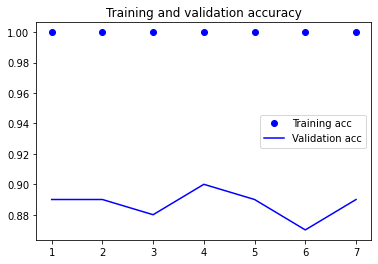

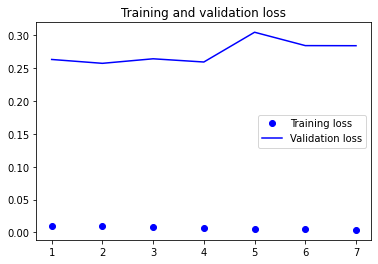

In [70]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [71]:

from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)


Train Accuracy:	 1.0
Val Accuracy:	 0.8899999856948853
Test Accuracy:	 0.9166666666666666
Precision:	 0.8461538461538461
Recall:		 0.9166666666666666
F1 Score:	 0.8799999999999999
AUC:		 0.9166666666666665
